In [514]:
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import numpy as np

from glob import glob

#### Tensorflow local stepup

In [515]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPU


In [516]:
import os

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

### Setup Init settings

In [517]:
BASE_PATH = "C:\\Users\\sktsa\\Projects\\visual-perception\\data\\mech\\"
TRAIN_PATH = BASE_PATH + 'train'
TEST_PATH = BASE_PATH + 'val'

In [518]:
image_files = glob(TRAIN_PATH + '/*/*.png')
image_test_files = glob(TEST_PATH + '/*/*.png')

#### Sanity check: Display random image 

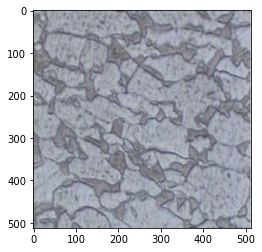

In [519]:
import matplotlib.pyplot as plt

plt.imshow(image.load_img(np.random.choice(image_files)))

### Transfer learning using RESNET-50

In [520]:
res_base = ResNet50(input_shape=IMAGE_SIZE + [3],
                    weights='imagenet',
                    include_top=False)
for layer in res_base.layers:
    layer.trainable = False

In [521]:
# Add 3 dense layers
x = Flatten()(res_base.output)
x = Dense(50, activation='relu')(x)
x = Dense(100, activation='relu')(x)
x = Dense(50, activation='relu')(x)
prediction = Dense(3)(x)

In [522]:
model = Model(inputs=res_base.input, outputs=prediction)

In [523]:
model.summary()

Model: "model_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_26[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

### Compile Model

In [524]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001, amsgrad=True)
model.compile(loss='mae', optimizer=adam, metrics=['accuracy'])


### Setup Image Augumentation

In [525]:
train_gen = ImageDataGenerator(rotation_range=20,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.1,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               vertical_flip=True,
                               preprocessing_function=preprocess_input)

# No augmentation for validation dataset
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)


In [526]:
# read csv
import pandas as pd
df = pd.read_csv(BASE_PATH + 'opt_feat1.csv', names=['U', 'Y', 'F'], skiprows=1)

# perform normalization on columns
x = df.values
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns=['U', 'Y', 'F'])

# Add images
df['image'] = ['{}//{}.png'.format(i, i) for i in range(1, len(df) + 1)]

# take 70% as training data
df_train = df.sample(frac = 0.7)
df_test = df.drop(df_train.index)
df_test

,U,Y,F,image
0,0.444444,0.076433,0.102564,1//1.png
1,0.462963,0.140127,0.230769,2//2.png
14,0.003704,0.208068,0.230769,15//15.png
18,0.166667,0.309979,0.217949,19//19.png
21,0.351852,0.458599,0.012821,22//22.png
24,0.370370,0.458599,0.230769,25//25.png
26,0.833333,0.840764,0.000000,27//27.png
27,0.518519,0.819533,0.320513,28//28.png
28,0.518519,0.819533,0.320513,29//29.png
30,0.844444,1.000000,1.000000,31//31.png


In [527]:
IMAGE_SIZE = [128, 128]
epochs = 50
BATCH_SIZE = 64

### Sanity check: Test Generators

In [528]:
test_gen = val_gen.flow_from_dataframe(df_train,
                                       TRAIN_PATH,
                                       x_col='image',
                                       y_col=['U', 'Y', 'F'],
                                       class_mode='raw',
                                       batch_size=BATCH_SIZE,
                                       target_size=IMAGE_SIZE)


Found 24 validated image filenames.


(24, 128, 128, 3) 24 [0.25925926 0.18259023 0.21794872]
min:  -87.68 max:  48.060997


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


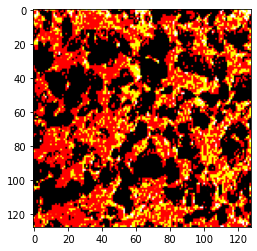

In [529]:
for x, y in test_gen:
    print(x.shape, len(y), y[0])
    print('min: ', x[0].min(), 'max: ', x[0].max())
    plt.imshow(x[0], cmap='binary')
    plt.show()
    break

## Begin Training

In [530]:
train_generator = train_gen.flow_from_dataframe(df_train,
                                                TRAIN_PATH,
                                                x_col='image',
                                                y_col=['U', 'Y', 'F'],
                                                class_mode='raw',
                                                batch_size=BATCH_SIZE,
                                                # subset='training',
                                                shuffle=True,
                                                target_size=IMAGE_SIZE)

val_generator = val_gen.flow_from_dataframe(df_test,
                                            TEST_PATH,
                                            x_col='image',
                                            batch_size=BATCH_SIZE,
                                            y_col=['U', 'Y', 'F'],
                                            class_mode='raw',
                                            # subset='validation',
                                            shuffle=True,
                                            target_size=IMAGE_SIZE)


Found 24 validated image filenames.
Found 10 validated image filenames.


In [531]:
print( train_generator.batch_size)

64


In [532]:
if train_generator.n < 32 or val_generator.n < 32:
    STEP_SIZE_TRAIN = 1
    STEP_SIZE_VALID = 1
else:
    STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
    STEP_SIZE_VALID = val_generator.n // val_generator.batch_size

r = model.fit(train_generator,
              validation_data=val_generator,
              epochs=epochs,
              steps_per_epoch=STEP_SIZE_TRAIN,
              validation_steps=STEP_SIZE_VALID)


Epoch 1/50
1/1 [==============================] - 4s 4s/step - loss: 0.5687 - accuracy: 0.4167 - val_loss: 0.5477 - val_accuracy: 0.5000
Epoch 2/50
1/1 [==============================] - 0s 436ms/step - loss: 0.6036 - accuracy: 0.1250 - val_loss: 0.4395 - val_accuracy: 0.6000
Epoch 3/50
1/1 [==============================] - 0s 405ms/step - loss: 0.5372 - accuracy: 0.2500 - val_loss: 0.4290 - val_accuracy: 0.3000
Epoch 4/50
1/1 [==============================] - 0s 322ms/step - loss: 0.5653 - accuracy: 0.4167 - val_loss: 0.4169 - val_accuracy: 0.2000
Epoch 5/50
1/1 [==============================] - 0s 324ms/step - loss: 0.5408 - accuracy: 0.4583 - val_loss: 0.3917 - val_accuracy: 0.1000
Epoch 6/50
1/1 [==============================] - 0s 326ms/step - loss: 0.4854 - accuracy: 0.5000 - val_loss: 0.3768 - val_accuracy: 0.3000
Epoch 7/50
1/1 [==============================] - 0s 329ms/step - loss: 0.3993 - accuracy: 0.5000 - val_loss: 0.3644 - val_accuracy: 0.3000
Epoch 8/50
1/1 [=======

In [533]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame.from_dict(r.history)

<AxesSubplot:>

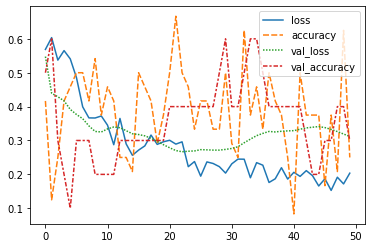

In [534]:
sns.lineplot(data=df)